# 1- Introduction

Nama : Ucik Refani Kurnia Sari

Kelas : FTDS Remote Batch 016

Objective : Classify an image of shoes, boots, and sandals using CNN

# 2- Import Libraries

In [1]:
#Import Libraries
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, Input

from sklearn.metrics import classification_report
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import warnings
warnings.filterwarnings('ignore')

# 3 - Data Loading 

In [2]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

In [3]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [4]:
# https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

 70% 33.0M/47.0M [00:00<00:00, 130MB/s] 
100% 47.0M/47.0M [00:00<00:00, 145MB/s]


In [5]:
# !unzip -q /content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d dataset
!unzip -q /content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d images

In [6]:
path_data ="/content/images/Shoe vs Sandal vs Boot Dataset"

In [7]:
# Lets check how many data we've got

path_data ="/content/images/Shoe vs Sandal vs Boot Dataset"
images = []
for i, j, s in os.walk(path_data):
    print(i)
    for im in s:   
        images.append(i+"/"+im)
print(f"Number of images:{len(images)}")

/content/images/Shoe vs Sandal vs Boot Dataset
/content/images/Shoe vs Sandal vs Boot Dataset/Sandal
/content/images/Shoe vs Sandal vs Boot Dataset/Boot
/content/images/Shoe vs Sandal vs Boot Dataset/Shoe
Number of images:15000


# 4 - Exploratory Data Analysis (EDA)

In [8]:
image_class = sorted(os.listdir(path_data))
image_class

['Boot', 'Sandal', 'Shoe']

In [9]:
n_classes = len(image_class)
print(f"Total Number of Classes : {n_classes}")

Total Number of Classes : 3


In [10]:
boot_num = os.listdir("/content/images/Shoe vs Sandal vs Boot Dataset/Boot")
len(boot_num)

5000

In [11]:
shoe_num = os.listdir("/content/images/Shoe vs Sandal vs Boot Dataset/Shoe")
len(shoe_num)

5000

In [12]:
sandal_num = os.listdir("/content/images/Shoe vs Sandal vs Boot Dataset/Sandal")
len(sandal_num)

5000

- there are 3 classes
- shoe, boot and sandal have the same amount of data which is 5000
- all categories are evenly distributed, so the data is not biased in certain classes

In [13]:
# create dataframe with paths and their 3 categories
data = pd.DataFrame(
    data = {"paths": images, "categories": [p.split("/")[-2] for p in images]}, 
)
# shuffle it
data = data.sample(frac = 1).reset_index() 
data.head()

,index,paths,categories
0,5532,/content/images/Shoe vs Sandal vs Boot Dataset...,Boot
1,13171,/content/images/Shoe vs Sandal vs Boot Dataset...,Shoe
2,10282,/content/images/Shoe vs Sandal vs Boot Dataset...,Shoe
3,5191,/content/images/Shoe vs Sandal vs Boot Dataset...,Boot
4,10672,/content/images/Shoe vs Sandal vs Boot Dataset...,Shoe


## Splitting Data

In [14]:
train_df, val_df = train_test_split(data, test_size=0.15, random_state=1, stratify = data['categories'])
train_df, test_df = train_test_split(data, test_size=0.15, random_state=1, stratify = data['categories'])
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(12750, 3)
(2250, 3)
(2250, 3)


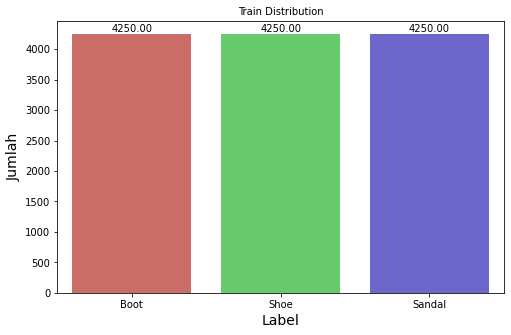

In [15]:
def visualize_data(dataframe, categories):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='categories', data=dataframe, palette='hls')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{categories} Distribution", size=10)
    plt.show()

visualize_data(train_df, 'Train')

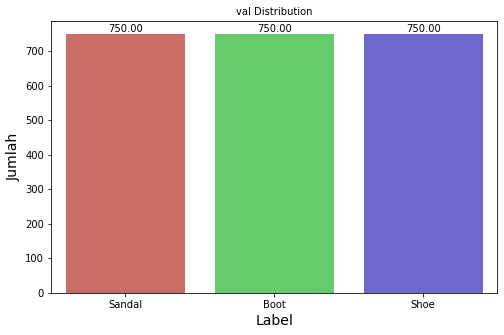

In [16]:
visualize_data(val_df, 'val')

Data balance on each train_df, val_df, and test_df.

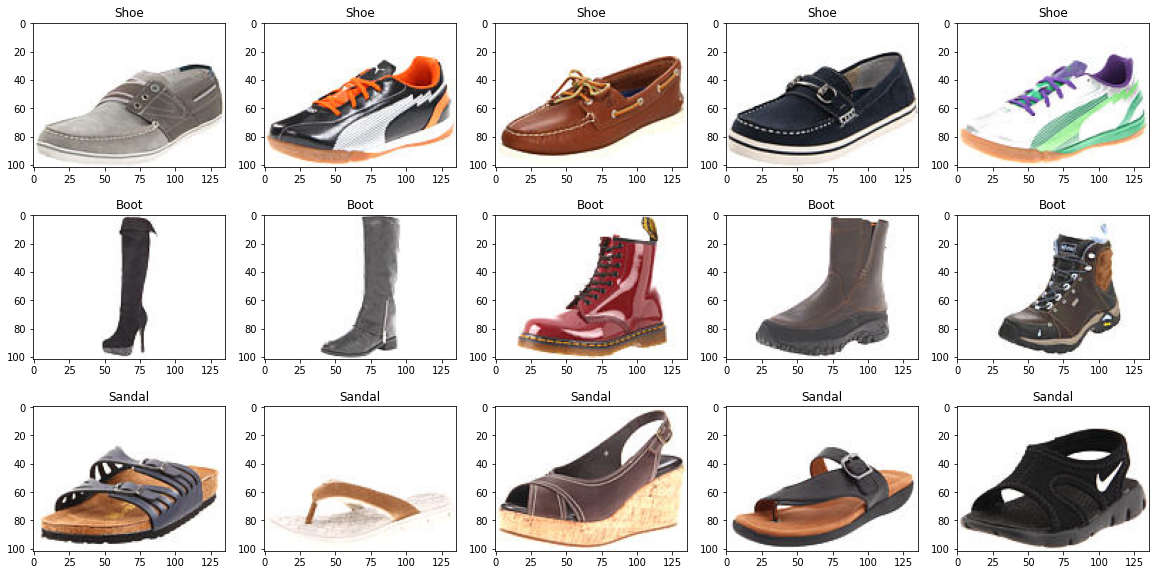

In [17]:
# Get few samples for both the classes
shoe_samples = (train_df[train_df['categories']=="Shoe"]['paths'].iloc[:5]).tolist()
boot_samples = (train_df[train_df['categories']=='Boot']['paths'].iloc[:5]).tolist()
sandal_samples = (train_df[train_df['categories']=='Sandal']['paths'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(shoe_samples + boot_samples + sandal_samples)

# 5 - Preprocessing Data

## Augmentasi Data

In [18]:
img_height= 102
img_width= 136
SEED = 1
BATCH =32

- rescale is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process (given a typical learning rate), so we target values between 0 and 1 instead by scaling with a 1/255. factor.
- rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
- horizontal_flip is for randomly flipping half of the images horizontally --relevant when there are no assumptions of horizontal assymetry.
- fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.



Reference: 
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [19]:
# create image generator
train_datagen = ImageDataGenerator(
    rescale=1./255, #pixel normalization
    rotation_range = 20,
    horizontal_flip=True,
    fill_mode = 'nearest')

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

Train generators, validation generators, and test generators are used for
the process of generating data based on data train, validation, and test. Determining a Batch size of 32 then when the data training process, 32 data will be taken randomly from all sample datasets for each epoch until all epochs meet the sample limit.

In [20]:
# dari dataframe bukan directory
dq_train = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='paths',
    y_col='categories',
    target_size=(img_height, img_width), #even out the size of the targets
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED)

dq_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='paths',
    y_col='categories',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

dq_test = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='paths',
    y_col='categories',
    target_size=(img_height, img_width),
    class_mode='categorical',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED)

Found 12750 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.
Found 2250 validated image filenames belonging to 3 classes.


In [21]:
dq_train.class_indices

{'Boot': 0, 'Sandal': 1, 'Shoe': 2}

# 6 - Sequential API 

## Model Definition

- stride is a parameter that determines how many filter shifts, the stride used is 2, so conv.filter will shift by 2 pixels.
- padding is a parameter that determines the number of pixels (containing a value of 0) to be added to each side of the input.
- The pooling layer consists of a filter with a certain size and stride that will shift throughout the feature map area.

- use categorical_crossentropy because the expected output is categorical.


Reference :
https://medium.com/@samuelsena/pengenalan-deep-learning-part-7-convolutional-neural-network-cnn-b003b477dc94

The ReLU (Rectified Linear Unit) function performs a “threshold” from 0 to infinity. In this function the input from the neurons is in the form of a negative number, then this function will translate that value into a value of 0, and if the input is positive then the output from the neuron is the activation value itself.

Softmax is a generalization of the logistics function. Softmax provides more intuitive results and also has a better probabilistic interpretation than other classification algorithms. Softmax allows us to calculate probabilities for all labels.

crossentropy is used when a class has quite a lot of classes. thus, it is necessary to have a way to measure the difference between the probability of the result of the hypothesis and the probability of the original truth, and during training many algorithms can adjust the parameters so that this difference is minimized. Use *categorical_crossentropy* because the model has 3 classes.

Accuracy is used as a parameter as accurately as a model performs classification.

In [22]:
callbacks1 = [
    EarlyStopping(monitor='val_loss', patience= 5),
    ModelCheckpoint('model_best.h5', monitor='val_loss', save_best_only=True)
]

I am using 2 Conv2D and 2 MaxPool layers alternated followed up by 2 Dense layers with the final layer being a softmax output.

Calculation of the number of kernels used depends on the number of features produced. The kernel size is 3. This means that every time you do a convolution, the 3x3 matrix is ​​input data multiplied by 3x3 which is filtered. Then proceed to the activation function, using the ReLU (Linear Rectifier Unit) activation function, then after exiting the activation function process then go through the pooling process. After going through the convolution process, the final result of max pooling will be converted into a two-dimensional vector form.

In [23]:
inputs= [img_height,img_width,3]

#arsitektur model sequential
model_seq1= Sequential()

#Layer Conv 1, bisa coba atur kernel_initializer dan activation
model_seq1.add(Conv2D(filters=32, kernel_size=3, activation='relu',
                       input_shape=inputs))
model_seq1.add(MaxPooling2D(pool_size= 2, strides=2))

#Layer Conv 2
model_seq1.add(Conv2D(filters=64, kernel_size=3, activation='relu'))               
model_seq1.add(MaxPooling2D(pool_size= 2, strides=2))

model_seq1.add(Flatten())
model_seq1.add(Dense(units=128, activation='relu'))
model_seq1.add(Dense(units=3,activation='softmax'))

model_seq1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics= ['accuracy'])

model_seq1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 134, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 67, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 65, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 128)               6

## Training Model

In [24]:
history= model_seq1.fit(dq_train, batch_size= BATCH, 
                           epochs= 30, validation_data= dq_val,
                           callbacks= callbacks1)

Epoch 1/30
399/399 [==============================] - 52s 111ms/step - loss: 0.4676 - accuracy: 0.8053 - val_loss: 0.3059 - val_accuracy: 0.8818
Epoch 2/30
399/399 [==============================] - 45s 113ms/step - loss: 0.2537 - accuracy: 0.9071 - val_loss: 0.1842 - val_accuracy: 0.9276
Epoch 3/30
399/399 [==============================] - 44s 110ms/step - loss: 0.1835 - accuracy: 0.9338 - val_loss: 0.1232 - val_accuracy: 0.9573
Epoch 4/30
399/399 [==============================] - 45s 112ms/step - loss: 0.1570 - accuracy: 0.9424 - val_loss: 0.0954 - val_accuracy: 0.9689
Epoch 5/30
399/399 [==============================] - 44s 109ms/step - loss: 0.1374 - accuracy: 0.9513 - val_loss: 0.1155 - val_accuracy: 0.9582
Epoch 6/30
399/399 [==============================] - 44s 110ms/step - loss: 0.1088 - accuracy: 0.9630 - val_loss: 0.1064 - val_accuracy: 0.9587
Epoch 7/30
399/399 [==============================] - 44s 109ms/step - loss: 0.1042 - accuracy: 0.9624 - val_loss: 0.0961 - val_ac

## Model Evaluation

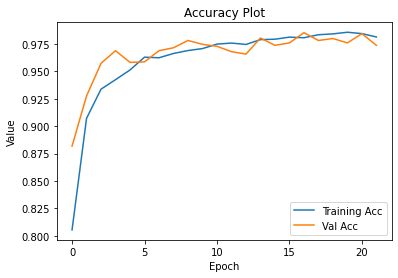

In [25]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

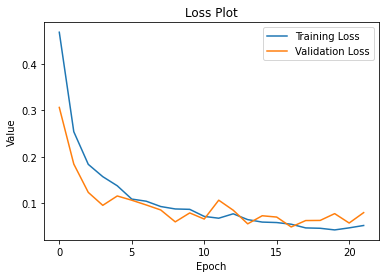

In [26]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [27]:
test_results = model_seq1.evaluate(dq_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.0797
Test Accuracy : 0.9738


In [28]:
y_pred = model_seq1.predict(dq_val)
y_pred = np.argmax(y_pred, axis = 1)
y_pred

71/71 [==============================] - 2s 21ms/step


array([1, 0, 1, ..., 2, 1, 0])

In [29]:
y_true = dq_val.classes

In [30]:
print(classification_report(dq_val.classes, y_pred, target_names = dq_val.class_indices.keys()))

              precision    recall  f1-score   support

        Boot       0.97      0.99      0.98       750
      Sandal       0.98      0.96      0.97       750
        Shoe       0.97      0.98      0.97       750

    accuracy                           0.97      2250
   macro avg       0.97      0.97      0.97      2250
weighted avg       0.97      0.97      0.97      2250



the results show that the model has an accuracy of 97.38%, meaning that it is able to correctly predict about 97.38%. to boot, has a precision value of 97%, meaning that it managed to predict correctly by 97%, while 3% predicted incorrectly. A recall value of 97% means that the model's success rate in retrieving information by correctly predicting it is 97%. The f1-score value is 98%.

the difference between the loss from the train set and the validation set is mostly around 0.02 in each epochs, while the loss from the train set tends to decrease to 0.07 as the epochs increase and approaches the loss value of the train. the loss from the validation set also tends to decrease to 0.07 as the epochs increase. from the Sequential API model curve is quite good, because train and validation have almost the same accuracy value as the epochs increase.

# 7-  Functional API 

## Model Definition

In [31]:
callbacks2 = [
    EarlyStopping(monitor='val_loss', patience= 6),
    ModelCheckpoint('model_best2.h5', monitor='val_loss', save_best_only=True)
]

The model holds an input layer, 2 hidden layers, 32 and 64 neurons, and a product layer with 3 output. 

After going through the convolution process, the final result of max pooling will be converted into a two-dimensional vector form.

Dropout value used is 0.2 and uses the sofmax activation function.

In [32]:
input_shape_img= Input(shape=inputs)

y= Conv2D(filters=32, kernel_size=3, activation='relu')(input_shape_img)
y= MaxPooling2D()(y)
y= Conv2D(filters=64, kernel_size=3, activation='relu')(y)
y= MaxPooling2D()(y)

# convert image to vector
y= Flatten()(y)
#dropout regularization
y= Dropout(0.2)(y)
outputs= Dense(3,activation='softmax')(y)
#Model building by supplying inputs/outputs
model_func1= Model(inputs=input_shape_img, outputs= outputs)

model_func1.compile(optimizer='Adam', loss='categorical_crossentropy', metrics= ['accuracy'])

model_func1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 102, 136, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 134, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 67, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 48, 65, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 24, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 49152)             0     

## Training Model

In [33]:
history= model_func1.fit(dq_train, batch_size= BATCH, 
                           epochs= 30, validation_data= dq_val,
                           callbacks= callbacks2)

Epoch 1/30
399/399 [==============================] - 44s 110ms/step - loss: 0.5037 - accuracy: 0.7946 - val_loss: 0.2755 - val_accuracy: 0.8996
Epoch 2/30
399/399 [==============================] - 44s 110ms/step - loss: 0.3291 - accuracy: 0.8778 - val_loss: 0.2362 - val_accuracy: 0.9164
Epoch 3/30
399/399 [==============================] - 44s 111ms/step - loss: 0.2771 - accuracy: 0.8984 - val_loss: 0.1763 - val_accuracy: 0.9409
Epoch 4/30
399/399 [==============================] - 44s 111ms/step - loss: 0.2387 - accuracy: 0.9165 - val_loss: 0.2005 - val_accuracy: 0.9302
Epoch 5/30
399/399 [==============================] - 45s 112ms/step - loss: 0.2073 - accuracy: 0.9270 - val_loss: 0.1583 - val_accuracy: 0.9444
Epoch 6/30
399/399 [==============================] - 45s 112ms/step - loss: 0.1970 - accuracy: 0.9298 - val_loss: 0.1953 - val_accuracy: 0.9427
Epoch 7/30
399/399 [==============================] - 45s 112ms/step - loss: 0.1798 - accuracy: 0.9369 - val_loss: 0.1385 - val_ac

## Model Evaluation 

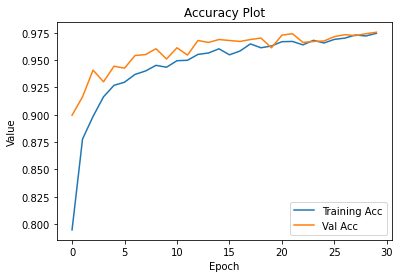

In [34]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

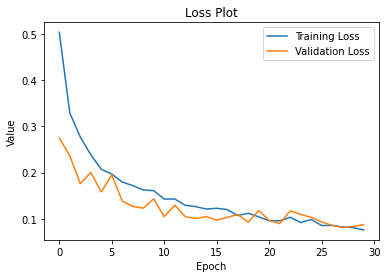

In [35]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [36]:
test_results = model_func1.evaluate(dq_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.0875
Test Accuracy : 0.9756


In [37]:
y_pred_func1 = model_func1.predict(dq_val, 32)
y_pred_func1 = np.argmax(y_pred_func1, axis = 1)
y_pred_func1

71/71 [==============================] - 1s 19ms/step


array([1, 0, 1, ..., 2, 1, 0])

In [38]:
y_true_func1 = dq_val.classes

In [39]:
print(classification_report(dq_val.classes, y_pred_func1, target_names = dq_val.class_indices.keys()))

              precision    recall  f1-score   support

        Boot       0.99      0.98      0.99       750
      Sandal       0.98      0.97      0.97       750
        Shoe       0.96      0.98      0.97       750

    accuracy                           0.98      2250
   macro avg       0.98      0.98      0.98      2250
weighted avg       0.98      0.98      0.98      2250



the results show that the model has an accuracy of 97.56%, meaning that it is able to correctly predict about 97.56%. to boot, has a precision value of 99%, meaning that it managed to predict correctly by 99%, while 1% predicted incorrectly. A recall value of 98% means that the model's success rate in retrieving information by correctly predicting it is 98%. The f1-score value is 99%.

the difference between the loss from the train set and the validation set is mostly around 0.01 in each epochs, while the loss from the train set tends to decrease to 0.08 as the epochs increase and approaches the loss value of the train. the loss from the validation set also tends to decrease to 0.08 as the epochs increase. from the Functional API model curve is quite good, because train and validation have almost the same accuracy value as the epochs increase.

# 8- Sequential API After Improvement 

In [40]:
callbacks3 = [
    EarlyStopping(monitor='val_loss', patience= 7),
    ModelCheckpoint('model_best3.h5', monitor='val_loss', save_best_only=True)
]

## Model Definition

I am using 2 Conv2D and 2 MaxPool layers alternated followed up by 2 Dense layers with the final layer being a softmax output. Additionally, I have added 3 Dropout Layers within the model to better assist with variance between train and test.

The Dropout layers are important as they "drop out," hence the name, certain nodes to reduce the likelikhood of the model overfitting.

I also want to finetune learning rate. Too high of a learning rate will cause the model to diverge. Too small of a learning rate will cause the model to be too slow. We implement the exponential learning rate scheduling method below.

In [41]:
inputs= [img_height,img_width,3]

#arsitektur model sequential
model_seq2= Sequential()

#Layer Conv 1, bisa coba atur kernel_initializer dan activation
model_seq2.add(Conv2D(filters=32, kernel_size=3, activation='relu',
                       input_shape=inputs))
model_seq2.add(MaxPooling2D(pool_size= 2, strides=2))
model_seq2.add(Dropout(0.25))

#Layer Conv 2
model_seq2.add(Conv2D(filters=64, kernel_size=3, activation='relu'))               
model_seq2.add(MaxPooling2D(pool_size= 2, strides=2))
model_seq2.add(Dropout(0.25))

model_seq2.add(Flatten())
model_seq2.add(Dense(units=128, activation='relu'))
model_seq2.add(Dropout(0.2))
model_seq2.add(Dense(units=3,activation='softmax'))

model_seq2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                    loss='categorical_crossentropy', metrics= ['accuracy'])

model_seq2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 134, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 67, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 50, 67, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 65, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 32, 64)       

## Training Model 

In [42]:
history= model_seq2.fit(dq_train, batch_size= BATCH, 
                           epochs= 30, validation_data= dq_val,
                           callbacks= callbacks3)

Epoch 1/30
399/399 [==============================] - 46s 115ms/step - loss: 0.6249 - accuracy: 0.7655 - val_loss: 0.3072 - val_accuracy: 0.8818
Epoch 2/30
399/399 [==============================] - 45s 112ms/step - loss: 0.2994 - accuracy: 0.8866 - val_loss: 0.1844 - val_accuracy: 0.9369
Epoch 3/30
399/399 [==============================] - 44s 110ms/step - loss: 0.2318 - accuracy: 0.9158 - val_loss: 0.1523 - val_accuracy: 0.9467
Epoch 4/30
399/399 [==============================] - 45s 112ms/step - loss: 0.2024 - accuracy: 0.9253 - val_loss: 0.1282 - val_accuracy: 0.9578
Epoch 5/30
399/399 [==============================] - 44s 109ms/step - loss: 0.1876 - accuracy: 0.9345 - val_loss: 0.1126 - val_accuracy: 0.9556
Epoch 6/30
399/399 [==============================] - 44s 110ms/step - loss: 0.1630 - accuracy: 0.9431 - val_loss: 0.1305 - val_accuracy: 0.9529
Epoch 7/30
399/399 [==============================] - 43s 108ms/step - loss: 0.1633 - accuracy: 0.9407 - val_loss: 0.1318 - val_ac

## Model Evaluation 

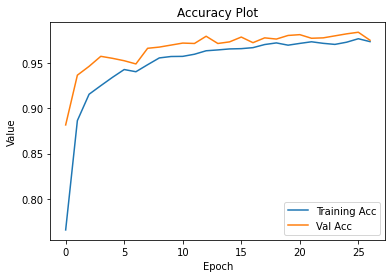

In [43]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

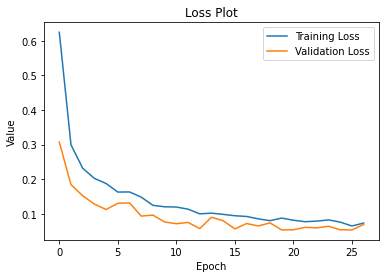

In [44]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [45]:
test_results = model_seq2.evaluate(dq_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.0693
Test Accuracy : 0.9756


In [46]:
y_pred_seq2 = model_seq2.predict(dq_val, 32)
y_pred_seq2 = np.argmax(y_pred_seq2, axis = 1)
y_pred_seq2

71/71 [==============================] - 2s 31ms/step


array([1, 0, 1, ..., 2, 1, 0])

In [47]:
y_true_seq2 = dq_val.classes

In [48]:
print(classification_report(dq_val.classes, y_pred_seq2, target_names = dq_val.class_indices.keys()))

              precision    recall  f1-score   support

        Boot       0.99      0.97      0.98       750
      Sandal       0.97      0.99      0.98       750
        Shoe       0.97      0.97      0.97       750

    accuracy                           0.98      2250
   macro avg       0.98      0.98      0.98      2250
weighted avg       0.98      0.98      0.98      2250



the results show that the model has an accuracy of 97.56%, meaning that it is able to correctly predict about 97.56%. to boot, has a precision value of 99%, meaning that it managed to predict correctly by 99%, while 1% predicted incorrectly. A recall value of 97% means that the model's success rate in retrieving information by correctly predicting it is 97%. The f1-score value is 98%.

the difference between the loss from the train set and the validation set is mostly around 0.01 in each epochs, while the loss from the train set tends to decrease to 0.06 as the epochs increase and approaches the loss value of the train. the loss from the validation set also tends to decrease up to 0.06 as the epochs increase. from the Sequential API improve model curve is quite good, because train and validation have almost the same accuracy value as the epochs increase.

In this improvement model, you can increase the metrics from previous experiments, because the learning rate that I use tends to be small, so the accuracy of the network will increase or increase with the consequence that the training process will take longer. so that better results are obtained.

# 9- Functional API After Improvement 

## Model Definition



I also want to finetune learning rate. Too high of a learning rate will cause the model to diverge. Too small of a learning rate will cause the model to be too slow. We implement the exponential learning rate scheduling method below.

In [49]:
callbacks4 = [
    EarlyStopping(monitor='val_loss', patience= 8),
    ModelCheckpoint('model_best4.h5', monitor='val_loss', save_best_only=True)
]

In [61]:
input_shape_img= Input(shape=inputs)

y= Conv2D(filters=32, kernel_size=3, activation='relu')(input_shape_img)
y= MaxPooling2D()(y)
y= Conv2D(filters=64, kernel_size=3, activation='relu')(y)
y= MaxPooling2D()(y)


# convert image to vector
y= Flatten()(y)
#dropout regularization
y= Dropout(0.2)(y)
outputs= Dense(3,activation='softmax')(y)
#Model building by supplying inputs/outputs
model_func2= Model(inputs=input_shape_img, outputs= outputs)

model_func2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate= 0.001), 
                    loss='categorical_crossentropy', metrics= ['accuracy'])
model_func2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 102, 136, 3)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 134, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 50, 67, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 48, 65, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 24, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 49152)             0   

## Training Model

In [62]:
history= model_func2.fit(dq_train, batch_size= BATCH, 
                           epochs= 30, validation_data= dq_val,
                           callbacks= callbacks4)

Epoch 1/30
399/399 [==============================] - 45s 109ms/step - loss: 0.5005 - accuracy: 0.7962 - val_loss: 0.2632 - val_accuracy: 0.9129
Epoch 2/30
399/399 [==============================] - 44s 108ms/step - loss: 0.3099 - accuracy: 0.8842 - val_loss: 0.2737 - val_accuracy: 0.8951
Epoch 3/30
399/399 [==============================] - 43s 108ms/step - loss: 0.2758 - accuracy: 0.9018 - val_loss: 0.1833 - val_accuracy: 0.9369
Epoch 4/30
399/399 [==============================] - 43s 107ms/step - loss: 0.2384 - accuracy: 0.9154 - val_loss: 0.1655 - val_accuracy: 0.9436
Epoch 5/30
399/399 [==============================] - 43s 107ms/step - loss: 0.2127 - accuracy: 0.9253 - val_loss: 0.1650 - val_accuracy: 0.9493
Epoch 6/30
399/399 [==============================] - 43s 109ms/step - loss: 0.1939 - accuracy: 0.9323 - val_loss: 0.1423 - val_accuracy: 0.9538
Epoch 7/30
399/399 [==============================] - 43s 108ms/step - loss: 0.1875 - accuracy: 0.9363 - val_loss: 0.1138 - val_ac

## Model Evaluation

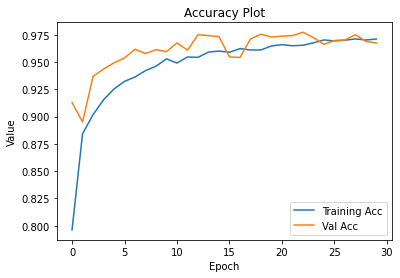

In [63]:
plt.plot(history.history['accuracy'], label='Training Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

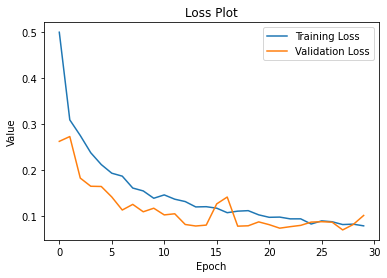

In [64]:
#loss train & validation
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

In [65]:
test_results = model_func2.evaluate(dq_test, verbose=0)
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

Test Loss     : 0.1020
Test Accuracy : 0.9676


In [66]:
y_pred_func2 = model_func2.predict(dq_val)
y_pred_func2 = np.argmax(y_pred_func2, axis = 1)
y_pred_func2

71/71 [==============================] - 1s 18ms/step


array([1, 0, 1, ..., 1, 1, 0])

In [67]:
y_true_func2 = dq_val.classes

In [68]:
print(classification_report(dq_val.classes, y_pred_func2, target_names = dq_val.class_indices.keys()))

              precision    recall  f1-score   support

        Boot       0.99      0.97      0.98       750
      Sandal       0.95      0.98      0.96       750
        Shoe       0.97      0.96      0.96       750

    accuracy                           0.97      2250
   macro avg       0.97      0.97      0.97      2250
weighted avg       0.97      0.97      0.97      2250



after training the Functional API improvement model with the following parameters: 2 hidden layers consisting of 32 and 64 activation hidden layers using ReLu.
The optimizer used is Adam with a learning rate = 0.001 which actually reduces performance, this is because the baseline Functional model already has maximum performance (close to 1) so that it can be said that it has reached its maximum point.

the difference between the loss of the training set and the validation set is mostly about 0.02 in each epochs, the loss of the training set tends to decrease to 0.08 as the epochs increase. curve is quite good, because train and validation have almost the same accuracy value as the epochs increase.

Of the four models that have been created and analyzed, the best model is obtained, namely the Improvement Model from the Sequential API, so that the model will be saved and used to make predictions from data inference

# 10 - Model Saving 

In [69]:
model_seq2.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 134, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 67, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 50, 67, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 65, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 32, 64)       

In [70]:
#freeze model

model_seq2.trainable = False
model_seq2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 100, 134, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 50, 67, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 50, 67, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 48, 65, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 24, 32, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 24, 32, 64)       

In [71]:
# Save CNN Model

model_seq2.save('shoe_model.h5')

# 11 - Model Inference 

In [72]:
# Load The Models
model_cnn = load_model('shoe_model.h5')

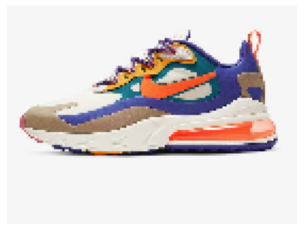

1/1 [==============================] - 0s 246ms/step
Result     :  [[0. 0. 1.]]
Max Class  :  2
Class Name :  Shoe



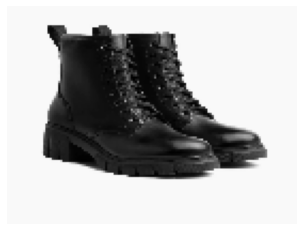

1/1 [==============================] - 0s 57ms/step
Result     :  [[1. 0. 0.]]
Max Class  :  0
Class Name :  Boot



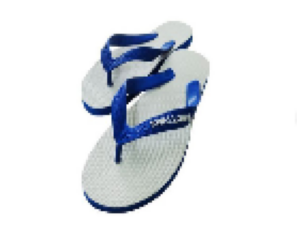

1/1 [==============================] - 0s 21ms/step
Result     :  [[0. 1. 0.]]
Max Class  :  1
Class Name :  Sandal



In [73]:
img_paths = ['/content/10-sneakers-terlaris-nike-rajanya-uwRqKNfOai.jpg',
             '/content/1024x1024-Women-Coda-Black-011422-3.4.jpg.webp',
             '/content/sandal-jepi-swallow-Tokopedia.jpg',]
 
for filename in img_paths:
  img = image.load_img(filename, target_size=(img_height, img_width))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

  img_array = tf.keras.preprocessing.image.img_to_array(img)
  img_batch = np.expand_dims(img_array, axis=0)

  prediction = model_cnn.predict(img_batch)
  result_max_proba = prediction.argmax(axis=-1)[0]
  result_class = image_class[result_max_proba]

  print('Result     : ', prediction)
  print('Max Class  : ', result_max_proba)
  print('Class Name : ', result_class)
  print('')

Based on 3 images taken from google, the CNN model can predict 100% correctly.

# 12 - Conclusion

The conclusions that can be drawn from the results of EDA and modeling in the presence of 4 different CNN models are:

The dataset consists of 3 classes, each of which has a total of 5000, which means the data is balanced. so, the data is not biased in certain classes. then, look at some of the pictures and distribution in each class.

After EDA is done, then data augmentation is performed, using rescale, horizontal_flip, rotation_range, and fill_mode. Train generators, validation generators, and test generators are used for the process of generating data based on data train, validation, and test.

Based on the sequential API baseline, an accuracy of 0.9738 is obtained, for the boot class the precision value is 97%, the recall value is 99%, and the f1score is 98%. Meanwhile, the functional API baseline obtained 98% accuracy, 99% precision value, 98% recall value, and 99% f1 score. where the functional API is higher than the sequential API.

then improved model for both models, sequential API model using dropout 0.2, learning rate = 0.001 and optimizer 'Adam', obtained accuracy which increased to 98%, precision value increased to 99%, recall value to 97%, and f1 score to 98%. this means an increase in the value of the metrics. This can work because the nodes are unequal in explanatory power in the training set. the neural network optimizes itself by assigning very high weights to these nodes. when running a dropout, it randomly kills some nodes, and in some cases will drop nodes and force the model to train as if they didn't exist. when a node is dropped, all its connections are killed. it adds multiplicative noise to the neural network as it will be multiplied by 1 or 0 (on or off). Besides that,learning rate that I use tends to be small, so the accuracy of the network will increase or increase with the consequence that the training process will take longer. so that better results are obtained.

on the Functional API improvement model using learning rate = 0.001 with optimizer = Adam. obtained 96.76% accuracy, 99% precision value, 97% recall value, and 98% f1 score. in this model it actually reduces performance with the addition of learning rate because in the baseline Functional API model it already has maximum performance (close to 1) so that it can be said to have reached its maximum point.

Based on the four existing models, the model that has the best metric value is the improvement model from the Sequential API, so the Sequential API model will be used to make predictions from data inference. from the prediction results using 3 images, the sequential API improvement model is able to predict 100% correctly.


## Recommendation

for further analysis, we can maximize the model with a more precise optimizer, for example Adamax because Adamax extends to the infinite norm(max) of the previous gradient, usually Adamax is superior to Adam. You can also use gradient clipping to improve the model.






